# Synthetic Hurricane Tweet Data Generator

This notebook generates synthetic tweet datasets that mimic the structure and patterns of real hurricane tweet data.

**Purpose:** Stress testing the rasterization pipeline with larger datasets

**Configurable Parameters:**
- Dataset size (number of tweets)
- Time range (duration and interval)
- Geographic extent
- Entity distributions (states, counties, cities, facilities)

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from shapely.geometry import Point
import json
import os

## Configuration Parameters

Adjust these to control the generated dataset size and characteristics

In [2]:
# ==============================================================================
# CONFIGURATION
# ==============================================================================

# Dataset size
NUM_TWEETS = 50000  # Change this! Original Helene = 3,007, Francine = 2,400

# Time parameters
START_TIME = datetime(2024, 9, 26, 0, 0, 0)  # Start datetime
DURATION_DAYS = 3  # Total duration in days

# Geographic extent (rough Southeast US bounding box)
LAT_MIN, LAT_MAX = 25.0, 42.0  # Florida to North Carolina
LON_MIN, LON_MAX = -90.0, -76.0  # Louisiana to Atlantic coast

# Hurricane name for output
HURRICANE_NAME = 'synthetic_test'

# Entity distribution (% of tweets mentioning each type)
STATE_MENTION_RATE = 0.70  # 70% mention states
COUNTY_MENTION_RATE = 0.15  # 15% mention counties
CITY_MENTION_RATE = 0.20  # 20% mention cities
FACILITY_MENTION_RATE = 0.04  # 4% mention facilities
MULTI_ENTITY_RATE = 0.30  # 30% mention multiple entities

print(f"Configuration:")
print(f"  Generating {NUM_TWEETS:,} synthetic tweets")
print(f"  Time range: {START_TIME} + {DURATION_DAYS} days")
print(f"  Geographic: ({LAT_MIN}, {LON_MIN}) to ({LAT_MAX}, {LON_MAX})")
print(f"  Hurricane: {HURRICANE_NAME}")

Configuration:
  Generating 50,000 synthetic tweets
  Time range: 2024-09-26 00:00:00 + 3 days
  Geographic: (25.0, -90.0) to (42.0, -76.0)
  Hurricane: synthetic_test


## Load Reference Lists

Extract entity names from the real dataset to use as templates

In [3]:
# Load reference data from real datasets
local_path = os.path.dirname(os.getcwd())
helene_path = os.path.join(local_path, 'data', 'geojson', 'helene.geojson')
francine_path = os.path.join(local_path, 'data', 'geojson', 'francine.geojson')

# Combine both datasets for variety
helene_gdf = gpd.read_file(helene_path)
francine_gdf = gpd.read_file(francine_path)
combined_gdf = pd.concat([helene_gdf, francine_gdf], ignore_index=True)

print(f"Loaded {len(combined_gdf):,} real tweets for reference")

Loaded 5,310 real tweets for reference


In [4]:
# Extract unique entity patterns from real data

# Parse GPE entities
all_gpe_entities = set()
for gpe_string in combined_gdf['GPE'].dropna():
    if gpe_string and str(gpe_string).strip():
        # Split by common delimiters
        entities = str(gpe_string).replace(',', '|').replace(';', '|').split('|')
        all_gpe_entities.update([e.strip() for e in entities if e.strip()])

# Parse facilities
all_facilities = set(combined_gdf[combined_gdf['FAC'] != '']['FAC'].dropna().unique())

# Create categorized entity lists (rough heuristics)
states = [
    'Florida', 'Georgia', 'North Carolina', 'South Carolina', 'Alabama',
    'Louisiana', 'Mississippi', 'Tennessee', 'Virginia', 'Texas',
    'FL', 'GA', 'NC', 'SC', 'AL', 'LA', 'MS', 'TN', 'VA', 'TX'
]

counties = [
    'Lafayette', 'Leon', 'Wakulla', 'Buncombe', 'Mecklenburg',
    'Fulton', 'DeKalb', 'Jefferson', 'Shelby', 'Davidson'
]

cities = list(all_gpe_entities - set(states) - set(counties))[:200]  # Sample
facilities = list(all_facilities)[:50]  # Sample

print(f"\nEntity libraries extracted:")
print(f"  States: {len(states)}")
print(f"  Counties: {len(counties)}")
print(f"  Cities: {len(cities)}")
print(f"  Facilities: {len(facilities)}")


Entity libraries extracted:
  States: 20
  Counties: 10
  Cities: 200
  Facilities: 50


## Generate Synthetic Dataset

In [5]:
def generate_timestamp(start, duration_days, num_tweets, index):
    """Generate timestamp with realistic distribution (more tweets during peak)"""
    # Use beta distribution for temporal clustering (peaks in middle)
    alpha, beta_param = 2, 2  # Symmetric peak
    normalized_time = np.random.beta(alpha, beta_param)
    seconds_offset = normalized_time * (duration_days * 86400)
    return start + timedelta(seconds=seconds_offset)

def generate_location(lat_min, lat_max, lon_min, lon_max):
    """Generate geographic coordinates with slight clustering"""
    # Add some spatial clustering (not purely random)
    # 80% clustered around major cities, 20% random
    if np.random.random() < 0.8:
        # Cluster around major cities
        hotspots = [
            (27.95, -82.46),  # Tampa
            (30.44, -84.28),  # Tallahassee
            (35.23, -80.84),  # Charlotte
            (33.75, -84.39),  # Atlanta
            (35.60, -82.55),  # Asheville
            (29.65, -82.32),  # Gainesville
        ]
        center = hotspots[np.random.randint(0, len(hotspots))]
        # Add noise around hotspot
        lat = center[0] + np.random.normal(0, 0.5)
        lon = center[1] + np.random.normal(0, 0.5)
    else:
        # Random location
        lat = np.random.uniform(lat_min, lat_max)
        lon = np.random.uniform(lon_min, lon_max)
    
    return lat, lon

def generate_gpe():
    """Generate GPE field (states, counties, cities)"""
    entities = []
    
    # State mentions
    if np.random.random() < STATE_MENTION_RATE:
        entities.append(np.random.choice(states))
    
    # County mentions
    if np.random.random() < COUNTY_MENTION_RATE:
        entities.append(np.random.choice(counties))
    
    # City mentions
    if np.random.random() < CITY_MENTION_RATE:
        if cities:  # Only if we have cities
            entities.append(np.random.choice(cities))
    
    # Multi-entity mentions
    if np.random.random() < MULTI_ENTITY_RATE and len(entities) > 0:
        # Add another random entity
        all_entities = states + counties + (cities if cities else [])
        entities.append(np.random.choice(all_entities))
    
    return ', '.join(entities) if entities else ''

def generate_fac():
    """Generate FAC field (facilities)"""
    if facilities and np.random.random() < FACILITY_MENTION_RATE:
        return np.random.choice(facilities)
    return ''

print("\nGenerating synthetic tweets...")

# Generate data
synthetic_data = []
for i in range(NUM_TWEETS):
    lat, lon = generate_location(LAT_MIN, LAT_MAX, LON_MIN, LON_MAX)
    
    record = {
        'FAC': generate_fac(),
        'LOC': '',  # LOC field appears unused in real data
        'GPE': generate_gpe(),
        'time': generate_timestamp(START_TIME, DURATION_DAYS, NUM_TWEETS, i),
        'Latitude': lat,
        'Longitude': lon,
        'make_polygon': 1,
        'geometry': Point(lon, lat)
    }
    synthetic_data.append(record)
    
    if (i + 1) % 10000 == 0:
        print(f"  Generated {i + 1:,} / {NUM_TWEETS:,} tweets")

# Create GeoDataFrame
synthetic_gdf = gpd.GeoDataFrame(synthetic_data, crs='EPSG:4326')

print(f"\n✓ Generated {len(synthetic_gdf):,} synthetic tweets")


Generating synthetic tweets...
  Generated 10,000 / 50,000 tweets
  Generated 20,000 / 50,000 tweets
  Generated 30,000 / 50,000 tweets
  Generated 40,000 / 50,000 tweets
  Generated 50,000 / 50,000 tweets

✓ Generated 50,000 synthetic tweets


## Validate Generated Data

In [6]:
print("\nDataset Statistics:")
print("=" * 60)
print(f"\nTotal records: {len(synthetic_gdf):,}")
print(f"\nTime range:")
print(f"  Start: {synthetic_gdf['time'].min()}")
print(f"  End: {synthetic_gdf['time'].max()}")
print(f"  Duration: {synthetic_gdf['time'].max() - synthetic_gdf['time'].min()}")

print(f"\nGeographic extent:")
print(f"  Latitude: {synthetic_gdf['Latitude'].min():.4f} to {synthetic_gdf['Latitude'].max():.4f}")
print(f"  Longitude: {synthetic_gdf['Longitude'].min():.4f} to {synthetic_gdf['Longitude'].max():.4f}")

print(f"\nEntity mentions:")
print(f"  GPE (non-empty): {(synthetic_gdf['GPE'] != '').sum():,} ({(synthetic_gdf['GPE'] != '').sum() / len(synthetic_gdf) * 100:.1f}%)")
print(f"  FAC (non-empty): {(synthetic_gdf['FAC'] != '').sum():,} ({(synthetic_gdf['FAC'] != '').sum() / len(synthetic_gdf) * 100:.1f}%)")

print(f"\nSample records:")
print(synthetic_gdf[['GPE', 'FAC', 'time', 'Latitude', 'Longitude']].head(10))


Dataset Statistics:

Total records: 50,000

Time range:
  Start: 2024-09-26 00:10:02.381743
  End: 2024-09-28 23:47:05.507814
  Duration: 2 days 23:37:03.126071

Geographic extent:
  Latitude: 25.0007 to 41.9999
  Longitude: -89.9966 to -76.0022

Entity mentions:
  GPE (non-empty): 39,922 (79.8%)
  FAC (non-empty): 1,976 (4.0%)

Sample records:
                           GPE FAC                       time   Latitude  \
0                                  2024-09-26 21:18:02.440660  31.788547   
1                           FL     2024-09-27 00:50:18.704245  36.004321   
2  The Sunshine State, AMERICA     2024-09-26 23:42:29.425472  30.228066   
3                                  2024-09-27 02:48:10.274000  36.089963   
4                           SC     2024-09-28 08:42:35.741005  35.546234   
5               North Carolina     2024-09-27 11:46:18.899695  36.461392   
6                   VA, Fulton     2024-09-26 15:24:33.198471  36.051885   
7                    Louisiana     2024-09-2

## Save Synthetic Dataset

In [7]:
# Save to GeoJSON
output_path = os.path.join(local_path, 'data', 'geojson', f'{HURRICANE_NAME}.geojson')
synthetic_gdf.to_file(output_path, driver='GeoJSON')

print(f"\n✓ Saved synthetic dataset to:")
print(f"  {output_path}")
print(f"\nFile size: {os.path.getsize(output_path) / 1024 / 1024:.2f} MB")
print(f"\nYou can now run the main processing notebook with this synthetic dataset!")


✓ Saved synthetic dataset to:
  C:\Users\colto\Documents\GitHub\Tweet_project\data\geojson\synthetic_test.geojson

File size: 14.18 MB

You can now run the main processing notebook with this synthetic dataset!


## Quick Comparison with Real Data

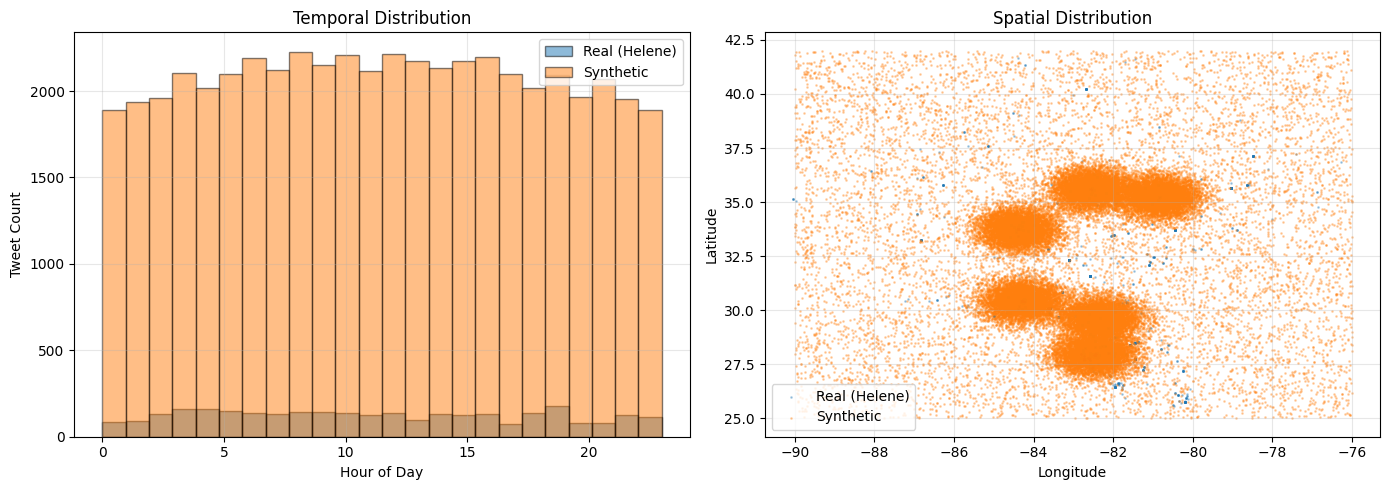


✓ Visual comparison complete


In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Temporal distribution
axes[0].hist(helene_gdf['time'].dt.hour, bins=24, alpha=0.5, label='Real (Helene)', edgecolor='black')
axes[0].hist(synthetic_gdf['time'].dt.hour, bins=24, alpha=0.5, label='Synthetic', edgecolor='black')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Tweet Count')
axes[0].set_title('Temporal Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Spatial distribution
axes[1].scatter(helene_gdf['Longitude'], helene_gdf['Latitude'], s=1, alpha=0.3, label='Real (Helene)')
axes[1].scatter(synthetic_gdf['Longitude'], synthetic_gdf['Latitude'], s=1, alpha=0.3, label='Synthetic')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Spatial Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visual comparison complete")